In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pdb
from utils import *

In [2]:
import os 
import data
import maml
import regressors
import copy

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [3]:
gen = data.SinusoidGenerator(batch_size = 16,
                 num_tasks = 256,
                 x_range = (-5, 5),
                 A_range = (0.1, 5),
                 P_range = (0, np.pi))

task = gen.generate_task()
task1 = task

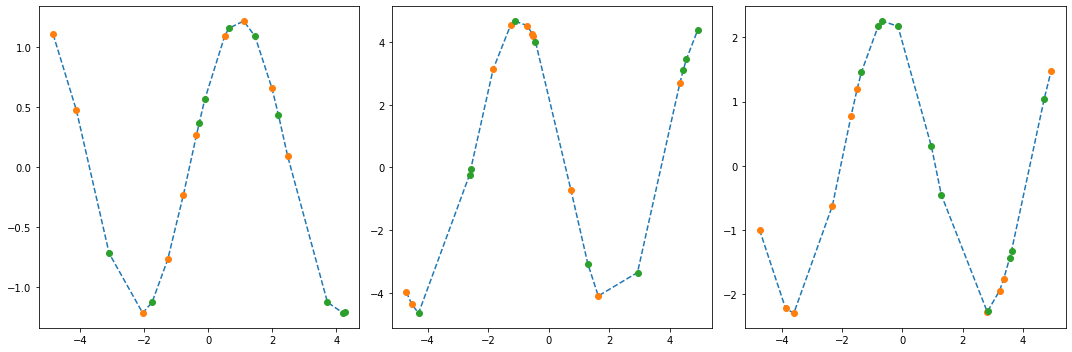

In [5]:
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows))

for idx, ax in enumerate(axes.flatten()):
    x = task['x'][idx,:,:].cpu()
    y = task['y'][idx,:,:].cpu()
    xc = task['x_context'][idx,:,:].cpu()
    yc = task['y_context'][idx,:,:].cpu()
    xt = task['x_target'][idx,:,:].cpu()
    yt = task['y_target'][idx,:,:].cpu()
    
    ax.plot(x,y,'--')
    ax.plot(xc,yc,'o')
    ax.plot(xt,yt,'o')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [6]:
%%capture
#fig, axes = plt.subplots(3,3,figsize=(20,15))
fig = plt.figure(figsize=(15,5))
for idx in range(task['x'].shape[0]):
    xc = task['x_context'][idx,:,:].cpu()
    yc = task['y_context'][idx,:,:].cpu()
    xt = task['x_target'][idx,:,:].cpu()
    yt = task['y_target'][idx,:,:].cpu()
    plt.plot(xc,yc,'o--')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [7]:
model = regressors.MLP(in_channels=1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
meta_model = maml.MAML_trainer(model, optimizer)

In [8]:
def test_inner_loop(task, idx, model, epoch, alpha=0.01):
    
    xc = task['x_context'][idx,:,:]
    yc = task['y_context'][idx,:,:]
    xt = task['x_target'][idx,:,:]
    yt = task['y_target'][idx,:,:]
    
    # Copy regressor to store updated params-> we don't want to update the actual meta-model
    updated_model = copy.deepcopy(model)
    #updated_model_params = updated_model.named_parameters()
    
    # Forward pass using support sets
    pred_c = updated_model(xc)
    loss_context = F.mse_loss(pred_c, yc)
    loss_context.backward()

    state_dict = updated_model.state_dict()
    
    # Manual backward pass
    for name, param in updated_model.named_parameters():
        #pdb.set_trace()
        #grad = param.grad.data
        grad = param.grad
        #print(param.sum())
        if grad is None:
            new_param = param
        else:
            new_param = param - alpha * grad.data # gradient descent
        
        state_dict[name] = new_param
        #copy_regressor_params[name] = new_param
        #print(new_param,sum())
        #with torch.no_grad():
            #param.copy_(new_param)
    
    updated_model.load_state_dict(state_dict)
    
    with torch.no_grad():
        pred_t = updated_model(xt)
        updated_loss_target = F.mse_loss(pred_t, yt)
        
    return pred_t, loss_context, updated_loss_target

def plot_example(task, num_plots, model, optimizer, epoch):
    
    fig, axes = plt.subplots(1,num_plots, figsize=(20,5))
    
    for idx, ax in enumerate(axes.flatten()):
        
        x = task['x'][idx,:,:]
        y = task['y'][idx,:,:]

        xc = task['x_context'][idx,:,:]
        yc = task['y_context'][idx,:,:]

        xt = task['x_target'][idx,:,:]
        yt = task['y_target'][idx,:,:]

        #pred, loss, after_loss = test(task, idx, model, optimizer, epoch)
        pred, loss_context, updated_loss_target = test_inner_loop(task, idx, model, epoch)

        ax.plot(x.cpu(),y.cpu(), '--')
        ax.plot(xc.cpu(),yc.cpu(), 'o')
        ax.plot(xt.cpu(),yt.cpu(), 'o')
        ax.plot(xt.cpu(), pred.cpu(), 'xb')
        ax.set_title("Epoch: {}: context loss {:.4f}: updated loss {:.4f}".format(epoch, loss_context, updated_loss_target))
    
    plt.show()

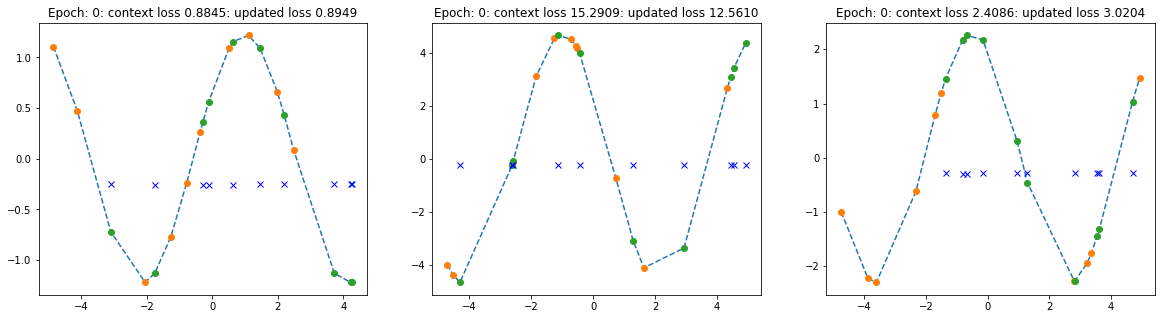

In [ ]:
num_epochs = 500
for epoch in range(num_epochs):
    for idx, task in enumerate(gen):
            
        meta_model.outer_loop_train(task['x_context'],
                          task['y_context'],
                          task['x_target'],
                          task['y_target'])
    
    task = gen.generate_task()
    if (epoch % 1) == 0:
        num_plots = 3
        plot_example(task1, num_plots, meta_model.regressor, meta_model.optimizer, epoch)

In [ ]:
def test(task, idx, model, optimizer, epoch):
    
    xc = task['x_context'][idx,:,:]
    yc = task['y_context'][idx,:,:]
    xt = task['x_target'][idx,:,:]
    yt = task['y_target'][idx,:,:]
    
    model.train()    
    # Forward pass using support sets
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    predictions = model(xc)
    loss = F.mse_loss(predictions, yc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred = model(xt)
        after_loss = F.mse_loss(predictions, yt)
    return pred, loss, after_loss
